# Method 7 - Best Fresh Ideas DGTW Timing

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Novus HFU

novus_hfu = hfu.get_novus_hfu()

# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)
dgtw_cont = dgtw_cont[dgtw_cont != 0]

rf = bi.get_risk_free_rate()
monthly_return = dgtw_cont.loc['1999-07-01':]
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

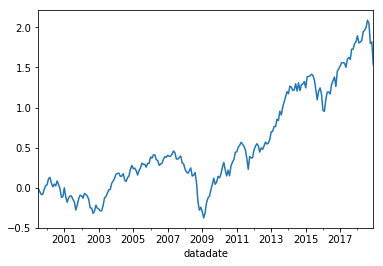

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.025504
2000-12-31   -0.135207
2001-12-31    0.022904
2002-12-31   -0.179997
2003-12-31    0.501515
2004-12-31    0.144659
2005-12-31    0.019244
2006-12-31    0.059153
2007-12-31   -0.058020
2008-12-31   -0.418820
2009-12-31    0.510340
2010-12-31    0.263213
2011-12-31   -0.048306
2012-12-31    0.169404
2013-12-31    0.370458
2014-12-31    0.056789
2015-12-31   -0.068010
2016-12-31    0.146925
2017-12-31    0.134982
2018-12-31   -0.101505
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     966.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.56e-142
Time:                        22:35:34   Log-Likelihood:                 697.11
No. Observations:                 234   AIC:                            -1384.
Df Residuals:                     229   BIC:                            -1367.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.262      0.208      -0.001       0.003
mktrf          0.9148      0.023     39.445      0.000       0.869       0.960
me             0.3759      0.027     13.935      0.000       0.323       0.429
ia             0.1331      0.041      3.248      0.001       0.052       0.214
roe           -0.3056      0.035     -8.708      0.000      -0.375      -0.236
==============================================================================
Omnibus:                       40.179   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              388.388
Skew:                           0.095   Prob(JB):                     4.60e-85
Kurtosis:                       9.309   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     559.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.76e-117
Time:                        22:35:34   Log-Likelihood:                 697.11
No. Observations:                 234   AIC:                            -1384.
Df Residuals:                     229   BIC:                            -1367.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.243      0.214      -0.001       0.003
mktrf          0.9148      0.033     28.145      0.000       0.851       0.978
me             0.3759      0.091      4.131      0.000       0.198       0.554
ia             0.1331      0.103      1.294      0.196      -0.069       0.335
roe           -0.3056      0.056     -5.479      0.000      -0.415      -0.196
==============================================================================
Omnibus:                       40.179   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              388.388
Skew:                           0.095   Prob(JB):                     4.60e-85
Kurtosis:                       9.309   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     617.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.45e-121
Time:                        22:35:34   Log-Likelihood:                 697.11
No. Observations:                 234   AIC:                            -1384.
Df Residuals:                     229   BIC:                            -1367.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.206      0.228      -0.001       0.003
mktrf          0.9148      0.028     33.160      0.000       0.861       0.969
me             0.3759      0.100      3.751      0.000       0.180       0.572
ia             0.1331      0.087      1.535      0.125      -0.037       0.303
roe           -0.3056      0.045     -6.731      0.000      -0.395      -0.217
==============================================================================
Omnibus:                       40.179   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              388.388
Skew:                           0.095   Prob(JB):                     4.60e-85
Kurtosis:                       9.309   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     674.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.07e-134
Time:                        22:35:34   Log-Likelihood:                 682.60
No. Observations:                 234   AIC:                            -1353.
Df Residuals:                     228   BIC:                            -1332.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.269      0.788      -0.002       0.002
mktrf          0.9622      0.025     38.830      0.000       0.913       1.011
smb            0.4722      0.033     14.443      0.000       0.408       0.537
hml            0.1880      0.039      4.876      0.000       0.112       0.264
rmw           -0.1382      0.044     -3.171      0.002      -0.224      -0.052
cma           -0.0896      0.055     -1.618      0.107      -0.199       0.020
==============================================================================
Omnibus:                       43.616   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              289.046
Skew:                           0.467   Prob(JB):                     1.72e-63
Kurtosis:                       8.364   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     468.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.46e-118
Time:                        22:35:34   Log-Likelihood:                 682.60
No. Observations:                 234   AIC:                            -1353.
Df Residuals:                     228   BIC:                            -1332.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.254      0.800      -0.002       0.002
mktrf          0.9622      0.028     34.814      0.000       0.908       1.016
smb            0.4722      0.070      6.753      0.000       0.335       0.609
hml            0.1880      0.061      3.076      0.002       0.068       0.308
rmw           -0.1382      0.054     -2.538      0.011      -0.245      -0.031
cma           -0.0896      0.095     -0.939      0.348      -0.277       0.097
==============================================================================
Omnibus:                       43.616   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              289.046
Skew:                           0.467   Prob(JB):                     1.72e-63
Kurtosis:                       8.364   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     472.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.29e-118
Time:                        22:35:34   Log-Likelihood:                 682.60
No. Observations:                 234   AIC:                            -1353.
Df Residuals:                     228   BIC:                            -1332.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.242      0.809      -0.002       0.002
mktrf          0.9622      0.026     36.369      0.000       0.910       1.014
smb            0.4722      0.071      6.620      0.000       0.332       0.612
hml            0.1880      0.059      3.193      0.001       0.073       0.303
rmw           -0.1382      0.048     -2.909      0.004      -0.231      -0.045
cma           -0.0896      0.099     -0.905      0.366      -0.284       0.105
==============================================================================
Omnibus:                       43.616   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              289.046
Skew:                           0.467   Prob(JB):                     1.72e-63
Kurtosis:                       8.364   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1382.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.90e-159
Time:                        22:35:34   Log-Likelihood:                 737.05
No. Observations:                 234   AIC:                            -1464.
Df Residuals:                     229   BIC:                            -1447.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.862      0.390      -0.001       0.002
mktrf          0.9137      0.018     50.754      0.000       0.878       0.949
smb            0.5531      0.022     24.616      0.000       0.509       0.597
hml            0.1566      0.022      7.017      0.000       0.113       0.201
umd           -0.1926      0.015    -13.148      0.000      -0.221      -0.164
==============================================================================
Omnibus:                       12.647   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               21.604
Skew:                          -0.292   Prob(JB):                     2.04e-05
Kurtosis:                       4.369   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1126.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.82e-149
Time:                        22:35:34   Log-Likelihood:                 737.05
No. Observations:                 234   AIC:                            -1464.
Df Residuals:                     229   BIC:                            -1447.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.802      0.422      -0.001       0.002
mktrf          0.9137      0.023     40.089      0.000       0.869       0.958
smb            0.5531      0.051     10.838      0.000       0.453       0.653
hml            0.1566      0.030      5.195      0.000       0.098       0.216
umd           -0.1926      0.028     -6.976      0.000      -0.247      -0.138
==============================================================================
Omnibus:                       12.647   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               21.604
Skew:                          -0.292   Prob(JB):                     2.04e-05
Kurtosis:                       4.369   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1224.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.12e-153
Time:                        22:35:34   Log-Likelihood:                 737.05
No. Observations:                 234   AIC:                            -1464.
Df Residuals:                     229   BIC:                            -1447.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.842      0.400      -0.001       0.002
mktrf          0.9137      0.024     38.506      0.000       0.867       0.960
smb            0.5531      0.052     10.688      0.000       0.452       0.655
hml            0.1566      0.028      5.563      0.000       0.101       0.212
umd           -0.1926      0.031     -6.195      0.000      -0.253      -0.132
==============================================================================
Omnibus:                       12.647   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               21.604
Skew:                          -0.292   Prob(JB):                     2.04e-05
Kurtosis:                       4.369   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     401.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.48e-66
Time:                        22:35:34   Log-Likelihood:                 331.99
No. Observations:                 120   AIC:                            -654.0
Df Residuals:                     115   BIC:                            -640.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      0.933      0.353      -0.002       0.004
mktrf          0.9263      0.040     23.123      0.000       0.847       1.006
me             0.3161      0.040      7.989      0.000       0.238       0.394
ia             0.1443      0.062      2.329      0.022       0.022       0.267
roe           -0.3044      0.055     -5.550      0.000      -0.413      -0.196
==============================================================================
Omnibus:                       16.461   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.312
Skew:                           0.224   Prob(JB):                     8.01e-14
Kurtosis:                       6.444   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     206.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.69e-51
Time:                        22:35:34   Log-Likelihood:                 331.99
No. Observations:                 120   AIC:                            -654.0
Df Residuals:                     115   BIC:                            -640.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.895      0.371      -0.002       0.004
mktrf          0.9263      0.051     18.009      0.000       0.825       1.027
me             0.3161      0.099      3.189      0.001       0.122       0.510
ia             0.1443      0.125      1.159      0.247      -0.100       0.388
roe           -0.3044      0.069     -4.381      0.000      -0.440      -0.168
==============================================================================
Omnibus:                       16.461   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.312
Skew:                           0.224   Prob(JB):                     8.01e-14
Kurtosis:                       6.444   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     223.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.96e-53
Time:                        22:35:34   Log-Likelihood:                 331.99
No. Observations:                 120   AIC:                            -654.0
Df Residuals:                     115   BIC:                            -640.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.839      0.402      -0.002       0.005
mktrf          0.9263      0.047     19.876      0.000       0.835       1.018
me             0.3161      0.109      2.887      0.004       0.102       0.531
ia             0.1443      0.105      1.370      0.171      -0.062       0.351
roe           -0.3044      0.057     -5.327      0.000      -0.416      -0.192
==============================================================================
Omnibus:                       16.461   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.312
Skew:                           0.224   Prob(JB):                     8.01e-14
Kurtosis:                       6.444   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     275.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.08e-62
Time:                        22:35:34   Log-Likelihood:                 324.02
No. Observations:                 120   AIC:                            -636.0
Df Residuals:                     114   BIC:                            -619.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.497      0.620      -0.002       0.004
mktrf          1.0201      0.045     22.498      0.000       0.930       1.110
smb            0.4460      0.051      8.685      0.000       0.344       0.548
hml            0.1629      0.063      2.588      0.011       0.038       0.288
rmw           -0.0917      0.074     -1.236      0.219      -0.239       0.055
cma           -0.0678      0.081     -0.834      0.406      -0.229       0.093
==============================================================================
Omnibus:                       19.873   Durbin-Watson:                   2.176
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.533
Skew:                           0.486   Prob(JB):                     4.35e-14
Kurtosis:                       6.371   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     362.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.02e-68
Time:                        22:35:34   Log-Likelihood:                 324.02
No. Observations:                 120   AIC:                            -636.0
Df Residuals:                     114   BIC:                            -619.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.518      0.604      -0.002       0.004
mktrf          1.0201      0.049     20.708      0.000       0.924       1.117
smb            0.4460      0.093      4.787      0.000       0.263       0.629
hml            0.1629      0.085      1.918      0.055      -0.004       0.329
rmw           -0.0917      0.077     -1.184      0.237      -0.243       0.060
cma           -0.0678      0.122     -0.557      0.578      -0.306       0.171
==============================================================================
Omnibus:                       19.873   Durbin-Watson:                   2.176
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.533
Skew:                           0.486   Prob(JB):                     4.35e-14
Kurtosis:                       6.371   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     522.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.79e-77
Time:                        22:35:34   Log-Likelihood:                 324.02
No. Observations:                 120   AIC:                            -636.0
Df Residuals:                     114   BIC:                            -619.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.499      0.618      -0.002       0.004
mktrf          1.0201      0.050     20.403      0.000       0.922       1.118
smb            0.4460      0.092      4.832      0.000       0.265       0.627
hml            0.1629      0.084      1.928      0.054      -0.003       0.328
rmw           -0.0917      0.074     -1.237      0.216      -0.237       0.054
cma           -0.0678      0.120     -0.564      0.573      -0.303       0.168
==============================================================================
Omnibus:                       19.873   Durbin-Watson:                   2.176
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.533
Skew:                           0.486   Prob(JB):                     4.35e-14
Kurtosis:                       6.371   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     629.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.70e-77
Time:                        22:35:34   Log-Likelihood:                 357.49
No. Observations:                 120   AIC:                            -705.0
Df Residuals:                     115   BIC:                            -691.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.775      0.440      -0.001       0.003
mktrf          0.9291      0.029     32.562      0.000       0.873       0.986
smb            0.5361      0.032     16.502      0.000       0.472       0.600
hml            0.1670      0.033      5.132      0.000       0.103       0.231
umd           -0.1989      0.020     -9.915      0.000      -0.239      -0.159
==============================================================================
Omnibus:                        2.257   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.324   Jarque-Bera (JB):                1.716
Skew:                          -0.245   Prob(JB):                        0.424
Kurtosis:                       3.321   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     720.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.10e-80
Time:                        22:35:34   Log-Likelihood:                 357.49
No. Observations:                 120   AIC:                            -705.0
Df Residuals:                     115   BIC:                            -691.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.801      0.423      -0.001       0.003
mktrf          0.9291      0.035     26.572      0.000       0.861       0.998
smb            0.5361      0.056      9.643      0.000       0.427       0.645
hml            0.1670      0.037      4.464      0.000       0.094       0.240
umd           -0.1989      0.034     -5.905      0.000      -0.265      -0.133
==============================================================================
Omnibus:                        2.257   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.324   Jarque-Bera (JB):                1.716
Skew:                          -0.245   Prob(JB):                        0.424
Kurtosis:                       3.321   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1032.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.47e-89
Time:                        22:35:34   Log-Likelihood:                 357.49
No. Observations:                 120   AIC:                            -705.0
Df Residuals:                     115   BIC:                            -691.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.986      0.324      -0.001       0.003
mktrf          0.9291      0.037     25.221      0.000       0.857       1.001
smb            0.5361      0.056      9.570      0.000       0.426       0.646
hml            0.1670      0.040      4.189      0.000       0.089       0.245
umd           -0.1989      0.039     -5.133      0.000      -0.275      -0.123
==============================================================================
Omnibus:                        2.257   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.324   Jarque-Bera (JB):                1.716
Skew:                          -0.245   Prob(JB):                        0.424
Kurtosis:                       3.321   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1174.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.35e-88
Time:                        22:35:34   Log-Likelihood:                 412.37
No. Observations:                 114   AIC:                            -814.7
Df Residuals:                     109   BIC:                            -801.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.542      0.012       0.000       0.003
mktrf          0.8555      0.020     43.783      0.000       0.817       0.894
me             0.5732      0.030     19.003      0.000       0.513       0.633
ia             0.0716      0.042      1.710      0.090      -0.011       0.154
roe           -0.3273      0.037     -8.903      0.000      -0.400      -0.254
==============================================================================
Omnibus:                        9.878   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               14.121
Skew:                           0.421   Prob(JB):                     0.000858
Kurtosis:                       4.505   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2022.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.05e-101
Time:                        22:35:35   Log-Likelihood:                 412.37
No. Observations:                 114   AIC:                            -814.7
Df Residuals:                     109   BIC:                            -801.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      3.024      0.002       0.001       0.003
mktrf          0.8555      0.018     47.927      0.000       0.820       0.890
me             0.5732      0.038     14.929      0.000       0.498       0.649
ia             0.0716      0.049      1.457      0.145      -0.025       0.168
roe           -0.3273      0.048     -6.844      0.000      -0.421      -0.234
==============================================================================
Omnibus:                        9.878   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               14.121
Skew:                           0.421   Prob(JB):                     0.000858
Kurtosis:                       4.505   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     3186.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.86e-112
Time:                        22:35:35   Log-Likelihood:                 412.37
No. Observations:                 114   AIC:                            -814.7
Df Residuals:                     109   BIC:                            -801.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      3.220      0.001       0.001       0.003
mktrf          0.8555      0.019     46.220      0.000       0.819       0.892
me             0.5732      0.042     13.674      0.000       0.491       0.655
ia             0.0716      0.052      1.365      0.172      -0.031       0.174
roe           -0.3273      0.051     -6.382      0.000      -0.428      -0.227
==============================================================================
Omnibus:                        9.878   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               14.121
Skew:                           0.421   Prob(JB):                     0.000858
Kurtosis:                       4.505   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     704.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-80
Time:                        22:35:35   Log-Likelihood:                 396.97
No. Observations:                 114   AIC:                            -781.9
Df Residuals:                     108   BIC:                            -765.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.627      0.532      -0.001       0.002
mktrf          0.8837      0.021     41.241      0.000       0.841       0.926
smb            0.5761      0.035     16.561      0.000       0.507       0.645
hml            0.1230      0.044      2.774      0.007       0.035       0.211
rmw           -0.2197      0.054     -4.044      0.000      -0.327      -0.112
cma           -0.0001      0.069     -0.002      0.998      -0.137       0.137
==============================================================================
Omnibus:                        9.342   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.566
Skew:                           0.576   Prob(JB):                      0.00837
Kurtosis:                       3.829   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1065.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.87e-90
Time:                        22:35:35   Log-Likelihood:                 396.97
No. Observations:                 114   AIC:                            -781.9
Df Residuals:                     108   BIC:                            -765.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.578      0.563      -0.001       0.002
mktrf          0.8837      0.017     51.681      0.000       0.850       0.917
smb            0.5761      0.036     15.856      0.000       0.505       0.647
hml            0.1230      0.057      2.170      0.030       0.012       0.234
rmw           -0.2197      0.058     -3.778      0.000      -0.334      -0.106
cma           -0.0001      0.065     -0.002      0.998      -0.128       0.128
==============================================================================
Omnibus:                        9.342   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.566
Skew:                           0.576   Prob(JB):                      0.00837
Kurtosis:                       3.829   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1536.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.39e-98
Time:                        22:35:35   Log-Likelihood:                 396.97
No. Observations:                 114   AIC:                            -781.9
Df Residuals:                     108   BIC:                            -765.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.514      0.607      -0.001       0.002
mktrf          0.8837      0.019     47.080      0.000       0.847       0.920
smb            0.5761      0.041     13.980      0.000       0.495       0.657
hml            0.1230      0.051      2.390      0.017       0.022       0.224
rmw           -0.2197      0.058     -3.765      0.000      -0.334      -0.105
cma           -0.0001      0.064     -0.002      0.998      -0.126       0.125
==============================================================================
Omnibus:                        9.342   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.566
Skew:                           0.576   Prob(JB):                      0.00837
Kurtosis:                       3.829   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     943.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.43e-83
Time:                        22:35:35   Log-Likelihood:                 400.27
No. Observations:                 114   AIC:                            -790.5
Df Residuals:                     109   BIC:                            -776.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.718      0.474      -0.001       0.002
mktrf          0.8843      0.021     42.949      0.000       0.843       0.925
smb            0.6339      0.032     19.746      0.000       0.570       0.698
hml            0.1392      0.033      4.210      0.000       0.074       0.205
umd           -0.1363      0.025     -5.463      0.000      -0.186      -0.087
==============================================================================
Omnibus:                        4.209   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                4.982
Skew:                           0.126   Prob(JB):                       0.0828
Kurtosis:                       3.993   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     890.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.14e-82
Time:                        22:35:35   Log-Likelihood:                 400.27
No. Observations:                 114   AIC:                            -790.5
Df Residuals:                     109   BIC:                            -776.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.656      0.512      -0.001       0.002
mktrf          0.8843      0.017     51.258      0.000       0.850       0.918
smb            0.6339      0.034     18.407      0.000       0.566       0.701
hml            0.1392      0.045      3.120      0.002       0.052       0.227
umd           -0.1363      0.020     -6.717      0.000      -0.176      -0.097
==============================================================================
Omnibus:                        4.209   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                4.982
Skew:                           0.126   Prob(JB):                       0.0828
Kurtosis:                       3.993   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1112.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.37e-87
Time:                        22:35:35   Log-Likelihood:                 400.27
No. Observations:                 114   AIC:                            -790.5
Df Residuals:                     109   BIC:                            -776.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.573      0.567      -0.001       0.002
mktrf          0.8843      0.017     51.208      0.000       0.850       0.918
smb            0.6339      0.036     17.790      0.000       0.564       0.704
hml            0.1392      0.044      3.155      0.002       0.053       0.226
umd           -0.1363      0.016     -8.521      0.000      -0.168      -0.105
==============================================================================
Omnibus:                        4.209   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                4.982
Skew:                           0.126   Prob(JB):                       0.0828
Kurtosis:                       3.993   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""